In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('DEVICE : ', DEVICE)

In [2]:
%run ../chap13/dataset_auto_mnist.ipynb
%run ../chap14/dataset_endec_mnist.ipynb

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('DEVICE : ', DEVICE)

DEVICE :  cuda:0


In [3]:
class EncEngDataset(Dataset):
    def __init__(self, data, labels):
        super(EncEngDataset).__init__()
        
        self.data = data
        self.labels = labels
    
    
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [5]:
def make_dataset(data):
    train_data = torch.from_numpy(data[0]).type(torch.Tensor)
    valid_data = torch.from_numpy(data[1]).type(torch.Tensor)
    test_data = torch.from_numpy(data[2]).type(torch.Tensor)
    
    return train_data, valid_data, test_data

def make_image(data):
    if type(data) == np.ndarray :
        data = torch.from_numpy(data).type(torch.Tensor)

    data = 0.5 * (data + 1)
    data = data.clamp(0, 1)
    data = data.view(data.size(0), 1, 28, 28)
    return data

def make_eng_label_to_vector(data):
    return data[:][:].argmax(-1)

EncEngDataset.make_data = make_dataset
EncEngDataset.make_img = make_image
EncEngDataset.make_label_vector = make_eng_label_to_vector

In [6]:
def vec_to_letter(result) :
    for c in np.squeeze(result) : 
        letter = chr(c+96) 
        if letter == '`' : 
            letter = '#'
        print(letter, end = '')
    print()
    #print('\t', end = '')
    
def visualizing_results(data) :
    embed = encoder(data)
    results = decoder.lettering(embed, out_size = 6)
    
    pltsize = 1
    for i in range(len(results)) :
        plt.figure(figsize = (pltsize, pltsize))
        plt.axis('off')
        plt.imshow(data[i][0],cmap='gray')
    
        vec_to_letter(results[i])

        plt.show()
        
def accuracy(test_images, test_captions):
    embed = encoder(test_images.to(DEVICE))
    results = decoder.lettering(embed.to(DEVICE), out_size = 6)
    cnt = 0
    
    for idx in range(len(results)):
        if str(results[idx]) == str(test_captions[idx,1:]):
            cnt += 1
    
    return cnt/len(results)

In [7]:
class FMnistEngDataset(EndecDataset):
    def __init__(self):
        super(FMnistEngDataset, self).__init__('mnist_eng', 'select', 'seqselect')

        images, labels = load_data()
        digits, words = self.set_captions(labels)

        self.shuffle_data(images, digits, words)

# def load_data():
#     tr_x_path = '../../data/chap13/f_mnist/train-images-idx3-ubyte'
#     tr_y_path = '../../data/chap13/f_mnist/train-labels-idx1-ubyte'

#     images = np.fromfile(tr_x_path, dtype='uint8')[16:]
#     labels = np.fromfile(tr_y_path, dtype='uint8')[8:]

#     return images.reshape([-1, 28*28]), labels

def fmnist_eng_set_captions(self, ys):
    self.target_names = ['tshirt', 'pants', 'lshirt', 'dress', 'coat', 'sandal', \
                         'shirt', 'shoes', 'bag', 'boot']

    words = np.zeros([10, 7, 27])
    words[:, 0, 0] = 6
    words[:, 1:, 0] = 1.0
    
    for n in range(10):
        word = self.target_names[n]
        for m in range(len(word)):
            alpha_idx = ord(word[m])-96
            words[n, m+1, :] = np.eye(27)[alpha_idx]

    captions = words[ys]
    digits = np.eye(10)[ys]
    
    return digits, captions
FMnistEngDataset.set_captions = fmnist_eng_set_captions

In [8]:
mnist_eng = MnistEngDataset()

img = mnist_eng.data[0]
onehot_label = mnist_eng.data[1]
eng_label = mnist_eng.data[2]

print('img \t\t type : ', type(img), ' \t shape : ', img[0].shape, '\t',  img[1].shape, '\t',  img[2].shape)
print('onehot label \t type : ', type(onehot_label), ' \t shape : ', onehot_label[0].shape, '\t',  onehot_label[1].shape, '\t',  onehot_label[2].shape)
print('eng label \t type : ', type(eng_label), ' \t shape : ', eng_label[0].shape,  eng_label[1].shape, '\t',  eng_label[2].shape)

img 		 type :  <class 'list'>  	 shape :  (48000, 784) 	 (3000, 784) 	 (9000, 784)
onehot label 	 type :  <class 'list'>  	 shape :  (48000, 10) 	 (3000, 10) 	 (9000, 10)
eng label 	 type :  <class 'list'>  	 shape :  (48000, 7, 27) (3000, 7, 27) 	 (9000, 7, 27)


In [9]:
train_x, valid_x, test_x = make_dataset(img)
train_y, valid_y, test_y = make_dataset(onehot_label)
train_z, valid_z, test_z = make_dataset(eng_label)

train_x = make_image(train_x)
valid_x = make_image(valid_x)
test_x = make_image(test_x)

train_z = make_eng_label_to_vector(train_z)
valid_z = make_eng_label_to_vector(valid_z)
test_z = make_eng_label_to_vector(test_z)

print('img data \t\ttrain_shape : ', train_x.shape, '\tvalid shape : ', valid_x.shape, '\ttest shape : ',  test_x.shape)
print('onehot label data \ttrain_shape : ', train_y.shape, '\t\tvalid shape : ', valid_y.shape, '\t\ttest shape : ',  test_y.shape)
print('eng label data \t\ttrain_shape : ', train_z.shape, '\t\tvalid shape : ', valid_z.shape, '\t\ttest shape : ',  test_z.shape)

img data 		train_shape :  torch.Size([48000, 1, 28, 28]) 	valid shape :  torch.Size([3000, 1, 28, 28]) 	test shape :  torch.Size([9000, 1, 28, 28])
onehot label data 	train_shape :  torch.Size([48000, 10]) 		valid shape :  torch.Size([3000, 10]) 		test shape :  torch.Size([9000, 10])
eng label data 		train_shape :  torch.Size([48000, 7]) 		valid shape :  torch.Size([3000, 7]) 		test shape :  torch.Size([9000, 7])


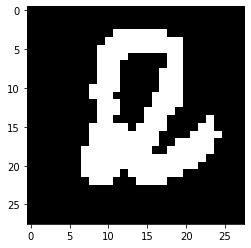

In [10]:
plt.imshow(train_x[0][0], cmap="gray")
plt.show()

In [11]:
f_train_loader = DataLoader(
    dataset=EncEngDataset(train_x, train_z), batch_size=100, shuffle=True
)
f_valid_loader = DataLoader(
    dataset=EncEngDataset(valid_x, valid_z), batch_size=100, shuffle=True
)
f_test_loader = DataLoader(
    dataset=EncEngDataset(test_x, test_z), batch_size=100, shuffle=True
)

for (X_train, y_train) in f_train_loader : 
    print('X_train : ', X_train.size() , ' \ttype : ', X_train.type())
    print('y_train : ', y_train.size() , ' \t\ttype : ', y_train.type())
    break

X_train :  torch.Size([100, 1, 28, 28])  	type :  torch.FloatTensor
y_train :  torch.Size([100, 7])  		type :  torch.LongTensor


In [7]:
import torchvision.models as models
display(models.resnet18())

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
class CNNEncoder(nn.Module):
    def __init__(self, pretrained = True, embed_size = 512):
        super(CNNEncoder, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1)
        self.pretrained_model = models.resnet18(pretrained=pretrained)
        self.prelu = nn.PReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.embed = nn.Linear(in_features=1000, out_features=embed_size)
        
    def forward(self, inp_img):
        inp = inp_img.to(DEVICE)
        print(inp.shape)
        out = self.conv1(inp)
        print(out.shape)
        out = self.pretrained_model(out)
        print(out.shape)
        out = self.prelu(out)
        print(out.shape)
        out = self.dropout(out)
        print(out.shape)
        out = self.embed(out)
        print(out.shape)
        
        return out


class RNNDecoder(nn.Module):
    def __init__(self, embed_size, hidden_size, letter_vec_size, num_layers=1):
        super(RNNDecoder, self).__init__()
        
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.letter_vec_size = letter_vec_size
        
        self.lstm_cell = nn.LSTMCell(input_size = embed_size, hidden_size = hidden_size)
        self.fc_out = nn.Linear(in_features=hidden_size, out_features=letter_vec_size)
        
        self.embed = nn.Embedding(num_embeddings=letter_vec_size, embedding_dim=embed_size)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, inp_emb, letter):
        batch_size = inp_emb.size(0)
        hidden_state = torch.zeros((batch_size, self.hidden_size)).to(DEVICE)
        cell_state = torch.zeros((batch_size, self.hidden_size)).to(DEVICE)
        outs = torch.empty((batch_size, letter.size(1), self.letter_vec_size))
        
        letter_embed = self.embed(letter)
        
        for idx in range(letter.size(1)):
            if idx == 0:
                hidden_state, cell_state = self.lstm_cell(inp_emb, (hidden_state, cell_state))
            else:
                hidden_state, cell_state = self.lstm_cell( [:,idx,:], (hidden_state, cell_state))
            
            out = self.fc_out(hidden_state)
            outs[:,idx,:] = out
            
        return outs
    
    def lettering(self, inp_embed, out_size):
        batch_size = inp_embed.size(0)
        hidden_state = torch.zeros((batch_size, self.hidden_size)).to(DEVICE)
        cell_state = torch.zeros((batch_size, self.hidden_size)).to(DEVICE)
        outs = torch.empty((batch_size, out_size, self.letter_vec_size))
        
        for idx in range(out_size):
            if idx != 0:
                inp_embed = self.embed(out.argmax(-1))
            hidden_state, cell_state = self.lstm_cell(inp_embed, (hidden_state, cell_state))
            out = self.fc_out(hidden_state)
            outs[:,idx,:] = out
        outs = outs.argmax(-1)
        
        return outs

In [14]:
embed_size = 512
pretrained = False

hidden_size = 512
letter_vec_size = 27
num_layers = 3

# total_step = len(f_train_loader)
total_step = 100
num_epochs = 5

encoder = CNNEncoder(embed_size=embed_size, pretrained = pretrained).to(DEVICE)
decoder = RNNDecoder(embed_size=embed_size, hidden_size=hidden_size, letter_vec_size=letter_vec_size, num_layers=num_layers).to(DEVICE)

criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.parameters())
optimizer = torch.optim.Adam(params, lr=0.0001)

losses = list()
val_losses = list()
acc = list()

t0 = time.time()

for epoch in range(1, num_epochs+1):
    
    for i_step in range(1, total_step+1):
        
        decoder.zero_grad()
        encoder.zero_grad()
        
        encoder.train()
        decoder.train()
        
        images, captions = next(iter(f_train_loader))
        images = images.to(DEVICE)
        captions = captions.to(DEVICE)
        
        captions_train = captions[:, :captions.shape[1]-1]
        captions_target = captions[:, 1:]

        
        features = encoder(images).to(DEVICE)
        outputs = decoder(features, captions_train).to(DEVICE)
        
        loss = criterion(outputs.view(-1, letter_vec_size), captions_target.contiguous().view(-1))
        
        loss.backward()
        
        optimizer.step()
        
        # - - - Validate - - -
        with torch.no_grad():
            
            encoder.eval()
            decoder.eval()

            val_images, val_captions = next(iter(f_valid_loader))
            
            val_iamges = val_images.to(DEVICE)
            val_captions = val_captions.to(DEVICE)

            captions_target = val_captions[:, 1:]
            captions_train = val_captions[:, :val_captions.shape[1]-1]

            features = encoder(val_images).to(DEVICE)
            outputs = decoder(features, captions_train).to(DEVICE)

            val_loss = criterion(outputs.view(-1, letter_vec_size), captions_target.contiguous().view(-1))
        
        val_losses.append(val_loss.item())
        losses.append(loss.item())
        acc.append(accuracy(test_x, test_z))
        
        stats = 'Epoch [%d/%d], Loss: %.4f, Val Loss: %.4f, accuracy: %.2f' % (epoch, num_epochs, loss.item(), val_loss.item(), accuracy(test_x, test_z))
        
        print('\rProcess in [%d/%d] step' % (i_step, total_step), end="")
        
        if i_step%(total_step/10) == 0 :
            print('\r', stats)
    print('\r', stats)


print('finished in {} seconds'.format(time.time() - t0))

print('validation accuracy is ', accuracy(test_x, test_z))

 Epoch [1/5], Loss: 2.8005, Val Loss: 2.8092, accuracy: 0.00
 Epoch [1/5], Loss: 2.3136, Val Loss: 2.3565, accuracy: 0.00
 Epoch [1/5], Loss: 1.7837, Val Loss: 1.8408, accuracy: 0.00
 Epoch [1/5], Loss: 1.3899, Val Loss: 1.5049, accuracy: 0.11
 Epoch [1/5], Loss: 1.0655, Val Loss: 1.2478, accuracy: 0.11
 Epoch [1/5], Loss: 0.7621, Val Loss: 0.8405, accuracy: 0.29
 Epoch [1/5], Loss: 0.5920, Val Loss: 0.5870, accuracy: 0.63
 Epoch [1/5], Loss: 0.4166, Val Loss: 0.4126, accuracy: 0.80
 Epoch [1/5], Loss: 0.3170, Val Loss: 0.3041, accuracy: 0.83
 Epoch [1/5], Loss: 0.2530, Val Loss: 0.2501, accuracy: 0.90
 Epoch [1/5], Loss: 0.2530, Val Loss: 0.2501, accuracy: 0.90
 Epoch [2/5], Loss: 0.1959, Val Loss: 0.1816, accuracy: 0.91
 Epoch [2/5], Loss: 0.1983, Val Loss: 0.1531, accuracy: 0.93
 Epoch [2/5], Loss: 0.1584, Val Loss: 0.1463, accuracy: 0.92
 Epoch [2/5], Loss: 0.1231, Val Loss: 0.1203, accuracy: 0.91
 Epoch [2/5], Loss: 0.1005, Val Loss: 0.1358, accuracy: 0.93
 Epoch [2/5], Loss: 0.08

In [26]:
def vec_to_label(result) :
    letter_string = ''
    
    for c in np.squeeze(result) : 
        letter = chr(c+96) 
        if letter == '`' : 
            letter = '#'
        letter_string = letter_string + letter
        
    return letter_string


def visualizing_results_grid(data, captions) :
    embed = encoder(data)
    results = decoder.lettering(embed, out_size = 6)
    
    pltsize = (2, 2)
    plt.figure(figsize = (10 * pltsize[0], 3 * pltsize[1]))
    
    for i in range(len(results)) :
        
        plt.subplot(3, 10, i + 1)
        plt.imshow(data[i][0],cmap='gray')
        plt.axis('off')
        plt.title(vec_to_label(results[i]), color='white' if vec_to_label(results[i]) == vec_to_label(captions[i]) else 'red')
        
    plt.subplots_adjust(hspace=0.3, wspace=0.0)
    plt.style.use('default')
    plt.show()

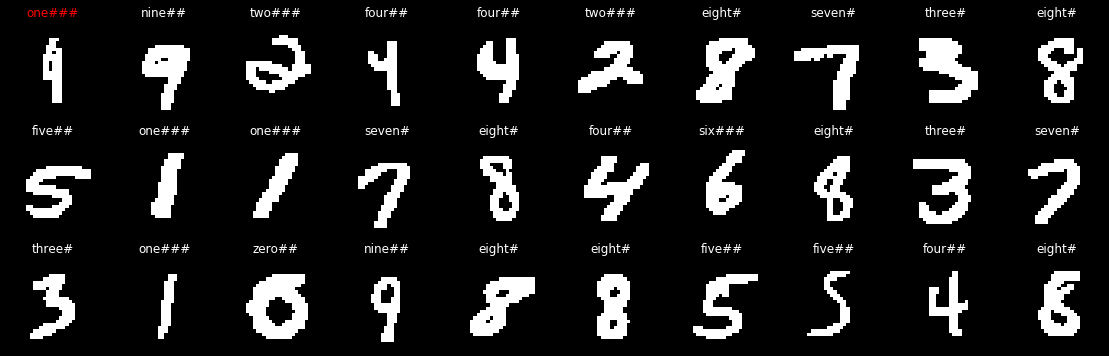

In [27]:
f_test_images, f_test_captions = next(iter(f_test_loader))
visualizing_results_grid(f_test_images[:30], f_test_captions[:30,1:])

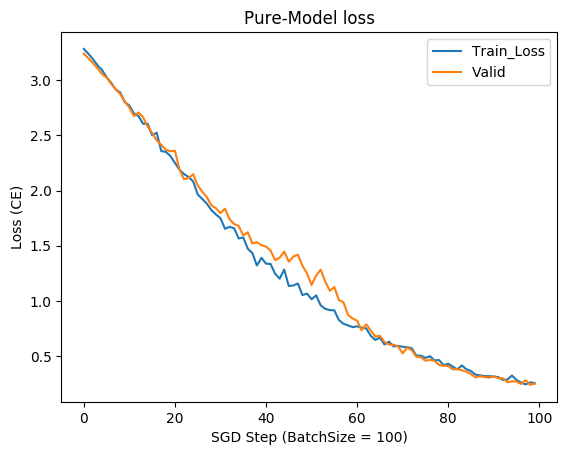

In [29]:
plt.plot(losses[:100])
plt.plot(val_losses[:100])
plt.title('Pure-Model loss')
plt.xlabel('SGD Step (BatchSize = 100)')
plt.ylabel('Loss (CE)')
plt.legend(['Train_Loss', 'Valid'], loc='upper right')
plt.show()

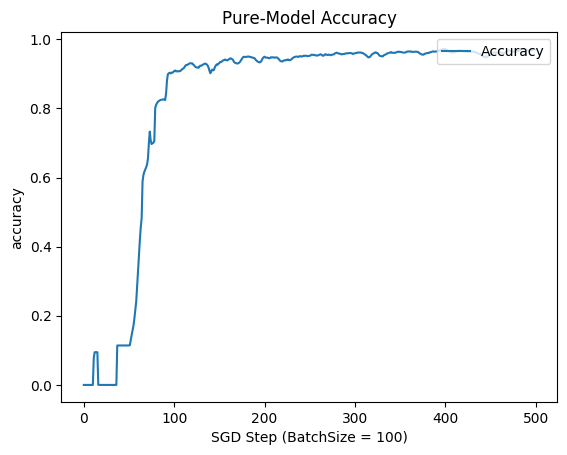

In [31]:
plt.style.use('default')
plt.plot(acc[:500])
plt.title('Pure-Model Accuracy')
plt.xlabel('SGD Step (BatchSize = 100)')
plt.ylabel('accuracy')
plt.legend(['Accuracy'], loc='upper right')
plt.show()

In [30]:
print('validation accuracy is ', accuracy(test_x, test_z))
print('임종성 202083349 ')

validation accuracy is  0.9705555555555555
임종성 202083349 
